In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import datasets

import matplotlib.pyplot as plt
from IPython import display
import time

In [3]:
(train_X, train_y), (test_X, test_y) = datasets.mnist.load_data()

In [4]:
train_X = (train_X / 127.5) - 1
test_X = (test_X / 127.5) - 1

In [5]:
clf = models.Sequential([
  layers.Flatten(input_shape=[28, 28]),
  layers.Dense(units=300, activation='relu'),
  layers.Dense(units=300, activation='relu'),
  layers.Dense(units=10, activation='softmax')
])

In [6]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________


In [7]:
clf.compile(optimizer='adam', 
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

## Minimalist GAN

In [8]:
coding_size = 100

generator = models.Sequential([
                               
  layers.Dense(200, activation='selu', input_shape=[coding_size]),
  layers.Dense(200, activation='selu'),
  layers.Dense(784, activation='sigmoid'),
  layers.Reshape([28, 28])
])


In [9]:
discriminator = models.Sequential([
  layers.Flatten(input_shape=[28,28]),
  layers.Dense(units=100, activation='selu'),
  layers.Dense(units=100, activation='selu'),
  layers.Dense(units=1, activation='sigmoid')
])

In [10]:
gan = models.Sequential([generator, discriminator])

#### Training loop
2 steps:
* D step: 
train only the discriminator on a batch of fake and real images
* G step:
freeze the discriminator, train the whole gan against a constant 1 y vector

In [11]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False # without this, the GAN doesn't train at all
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')


In [12]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [21]:
seed = tf.random.normal([16, coding_size])

def train_loop(gan, dataset, batch_size, coding_size, n_epochs=50, reshape=None):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):

    
    generate_and_save_images(generator, epoch, seed)

    start = time.time()
    for X_batch in dataset:
      X_batch = tf.cast(X_batch, tf.float32) # it needs float32
      if reshape:
          X_batch = tf.reshape(X_batch, reshape)

      # D step
      noise = tf.random.normal(shape=[batch_size, coding_size])
      generated = generator(noise)
      fake_real = tf.concat([generated, X_batch], axis=0)
      y = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

      discriminator.trainable = True
      discriminator.train_on_batch(fake_real, y)

      # G step
      noise = tf.random.normal(shape=[batch_size, coding_size])
      y2 = tf.constant([[1.]] * batch_size)

      discriminator.trainable = False
      gan.train_on_batch(noise, y2)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


Vizualizations

In [22]:

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

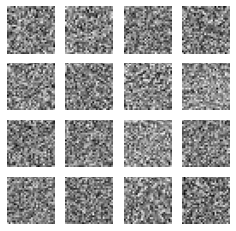

Time for epoch 1 is 34.64668607711792 sec


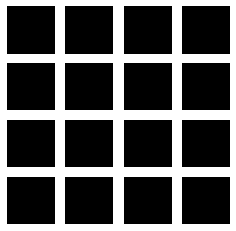

Time for epoch 2 is 32.248398780822754 sec


In [15]:
train_loop(gan, dataset, batch_size, coding_size=coding_size, n_epochs=2)

In [16]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 88,701
Trainable params: 0
Non-trainable params: 88,701
_________________________________________________________________


In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

disc2 = make_discriminator_model()
gen2 = make_generator_model()
dcgan = models.Sequential([gen2, disc2])

In [18]:
disc2.compile(loss='binary_crossentropy', optimizer='rmsprop')
disc2.trainable = False # without this, the GAN doesn't train at all
dcgan.compile(loss='binary_crossentropy', optimizer='rmsprop')


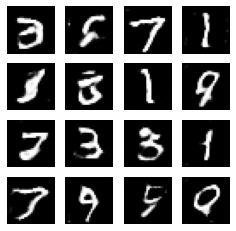

Time for epoch 1 is 631.1766731739044 sec


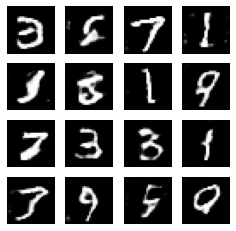

In [ ]:
train_loop(dcgan, dataset, batch_size, coding_size=100, n_epochs=50, reshape=[batch_size, 28, 28, 1])

In [20]:
for batch in dataset:
    reshaped = tf.reshape(batch, [32*28*28])
    print(reshaped.shape)
    break

(25088,)
